In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# load cleaned data
df = pd.read_csv("data/HR_data_cleaned.csv")

In [26]:
df.columns

Index(['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew',
       'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std',
       'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max',
       'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT', 'Individu

### Feature selection

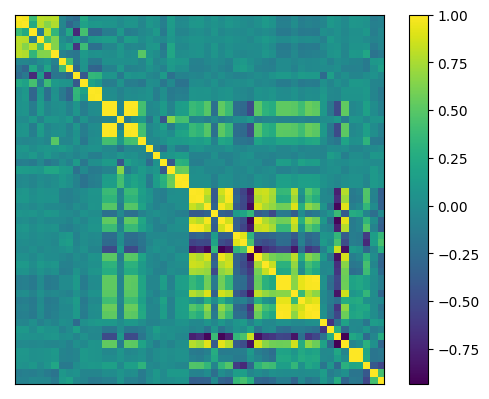

In [27]:
# feature selection by correlation between columns

def select_cols_to_drop(df, corr_cutoff):
    # continuous columns
    continuous_cols = df.columns[0:51]

    # absolute value of correlation matrix
    corr_matrix = df[continuous_cols].corr().abs()

    # upper triangular array of True booleans
    bool_array = np.ones(corr_matrix.shape).astype(bool)
    T = np.triu(bool_array, 1)

    T_corr_matrix = corr_matrix.where(T)

    # array of columns to drop
    drop_cols = []

    # drop columns that have at least corr_cutoff absolute correlation with at least one other column
    col_arr = T_corr_matrix.columns
    for col in col_arr:
        if any(T_corr_matrix[col] > corr_cutoff):
            T_corr_matrix = T_corr_matrix.drop(columns=col)
            drop_cols.append(col)
    
    return drop_cols

# plot absolute value correlation matrix (without taking absolute value first)
continuous_cols = df.columns[0:51]
plt.imshow(df[continuous_cols].corr())
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

### Scatter matrix plot of the least correlated features

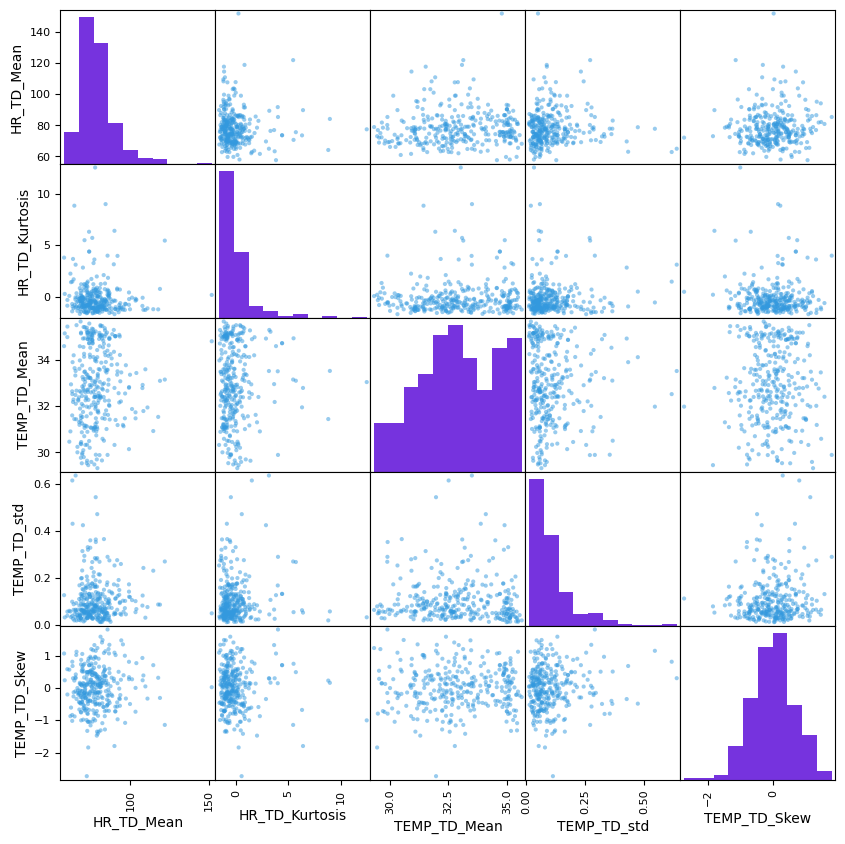

In [28]:
from pandas.plotting import scatter_matrix

# use non standardized data for histograms
df_no_s = pd.read_csv("data/HR_data.csv")

# select features to plot (corr_cutoff=0.15 drops 46 features such that we have 5 left)
drop_cols = select_cols_to_drop(df, corr_cutoff=0.15)

cols = df_no_s[continuous_cols].drop(columns=drop_cols).columns
df2 = df_no_s[cols]

# scatter/histogram matrix plot of the 5 features with least correlation with all other features
scatter_mat = scatter_matrix(df2, figsize=(10,10), hist_kwds={"color": "#7633de"}, color="#3399de")

### Clustering

In [29]:
# select features to use for clustering

drop_cols = select_cols_to_drop(df, corr_cutoff=0.8)
print(f"Number of columns to drop: {len(drop_cols)}")

cluster_cols = df[continuous_cols].drop(columns=drop_cols).columns
print(f"Number of columns to use for clustering: {len(cluster_cols)}")
print(f"Columns: {cluster_cols}")

Number of columns to drop: 25
Number of columns to use for clustering: 26
Columns: Index(['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean',
       'TEMP_TD_Mean', 'TEMP_TD_std', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis',
       'TEMP_TD_Skew', 'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max',
       'TEMP_TD_Slope_mean', 'EDA_TD_P_Mean', 'EDA_TD_P_Min',
       'EDA_TD_P_Kurtosis', 'EDA_TD_T_Mean', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_mean', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT',
       'EDA_TD_P_ReT'],
      dtype='object')


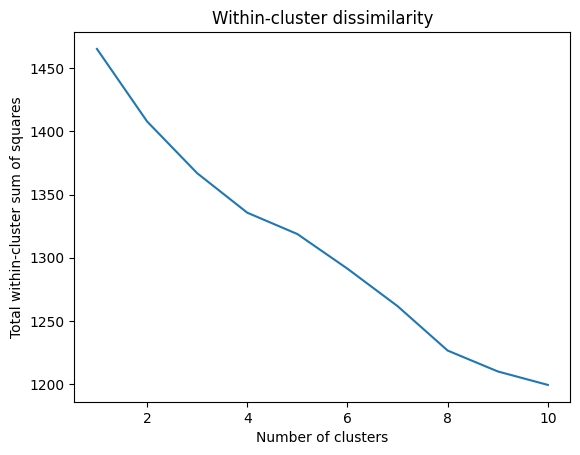

In [30]:
# compute total within-cluster sum of squares for different values of k

# try k clusters for k=1..10
def compute_WCSS(df, max_K = 10):
    number_of_clusters = np.arange(1, max_K+1)

    data = df.to_numpy()
    WCSS = []
    for k in number_of_clusters:

        # kmeans clustering
        kmeans = KMeans(n_clusters=k, random_state=1).fit(df)

        SS = 0
        for i in range(kmeans.cluster_centers_.shape[0]):
            
            center = kmeans.cluster_centers_[i,:]

            # get indices of observations in current cluster
            cluster_idx = (kmeans.labels_ == i)
            data_cluster = data[cluster_idx,:]

            dist_array = np.linalg.norm(data_cluster-center, axis=1)
            SS += np.sum(dist_array)
        
        WCSS.append(SS)
    
    return WCSS


max_K = 10
K_arr = np.arange(1, max_K+1)
WCSS = compute_WCSS(df[cluster_cols], max_K=10)

plt.plot(K_arr, WCSS)
plt.xlabel("Number of clusters")
plt.ylabel("Total within-cluster sum of squares")
plt.title("Within-cluster dissimilarity")
plt.savefig("results/cluster_dissimilarity.pdf")
plt.show()



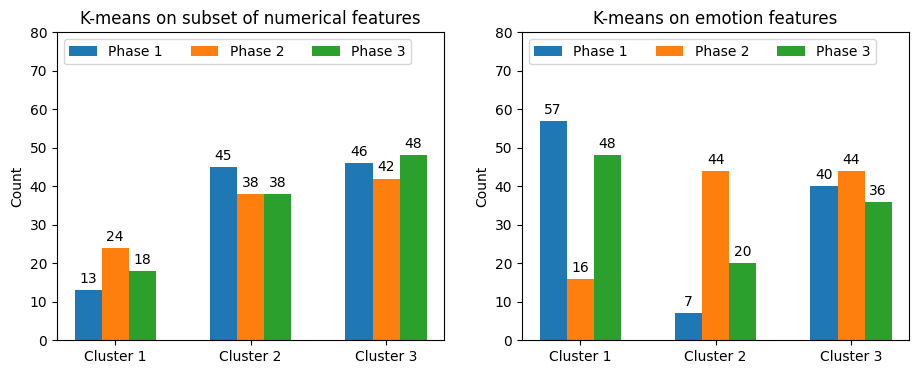

In [31]:
def get_counts(labels):
    phases = ["Phase_0", "Phase_1", "Phase_2"]
    counts = []
    for i in range(len(phases)):
        phase_idx = df.index[df[phases[i]] == True].to_numpy()

        _, count = np.unique(labels[phase_idx], return_counts=True)
        
        if len(count) < 3:
            count = np.insert(count, 0, 0)
        
        counts.append(count)

    return counts

#### first subplot ####

kmeans = KMeans(n_clusters=3, random_state=0).fit(df[cluster_cols])
labels = kmeans.labels_

counts = get_counts(labels)

clusters = ("Cluster 1", "Cluster 2", "Cluster 3")
data = {
    "Phase 1": tuple(counts[0]),
    "Phase 2": tuple(counts[1]),
    "Phase 3": tuple(counts[2])
}

tick_space = np.arange(len(clusters))
width = 0.2
mult = 0
colors = ["#3399de", "#33de5a", "#7633de"]

fig, ax = plt.subplots(1,2,figsize=(11,4))

for i, (phase, count) in enumerate(data.items()):
    bar_offset = width * mult
    rects = ax[0].bar(tick_space + bar_offset, count, width, label=phase)
    ax[0].bar_label(rects, padding=3)
    mult += 1

ax[0].set_xticks(tick_space + width, clusters)
ax[0].set_ylim(0, 80)
ax[0].legend(loc="upper left", ncols=3)
ax[0].set_ylabel("Count")
ax[0].set_title("K-means on subset of numerical features")



#### second subplot ####
ordinal_cols = df.columns[53:64]

kmeans = KMeans(n_clusters=3, random_state=0).fit(df[ordinal_cols])
labels = kmeans.labels_

counts = get_counts(labels)
data = {
    "Phase 1": tuple(counts[0]),
    "Phase 2": tuple(counts[1]),
    "Phase 3": tuple(counts[2])
}

for i, (phase, count) in enumerate(data.items()):
    bar_offset = width * mult
    rects = ax[1].bar(tick_space + bar_offset, count, width, label=phase)
    ax[1].bar_label(rects, padding=3)
    mult += 1

ax[1].set_xticks(tick_space + width + 0.6, clusters)
ax[1].set_ylim(0, 80)
ax[1].legend(loc="upper left", ncols=3)
ax[1].set_ylabel("Count")
ax[1].set_title("K-means on emotion features")

plt.savefig("results/cluster_phase2.png")

plt.show()


### Clustering on a selection of 3 numerical features

##### Choosing K with WCSS and silhouette score

In [32]:
df.columns[0:51]

Index(['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew',
       'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std',
       'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max',
       'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT'],
      dt

In [33]:
# define features to cluster
cols = df.columns[4:5].append(df.columns[16:17]).append(df.columns[28:29])

print(f"Features to cluster: {cols}")

Features to cluster: Index(['HR_TD_Max', 'TEMP_TD_Max', 'EDA_TD_P_Max'], dtype='object')


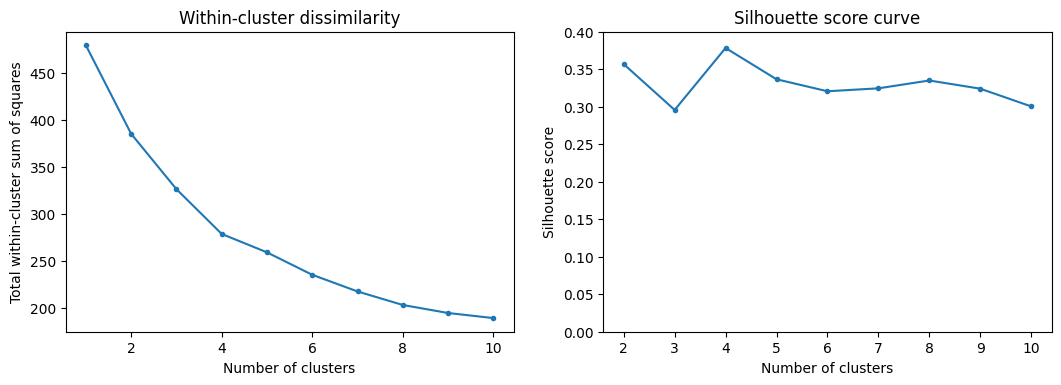

In [34]:
X = df[cols]

# WCSS (within-cluster sum of squares)
max_K = 10
K_arr = np.arange(1, max_K+1)
WCSS = compute_WCSS(X, max_K=10)

fig, ax = plt.subplots(1, 2, figsize=(11,4))
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(top=0.9)
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(left=0.08)

ax[0].plot(K_arr, WCSS, marker=".")

ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Total within-cluster sum of squares")
ax[0].set_title("Within-cluster dissimilarity")


# Silhouette score
sil_scores = []
for k in range(2, max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = kmeans.labels_
    sil_score = silhouette_score(X, labels)
    sil_scores.append(sil_score)

ax[1].plot(np.arange(2, max_K+1), sil_scores, marker=".")
ax[1].set_ylim(ymin=0, ymax=0.40)

ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Silhouette score curve")

plt.savefig("results/WCSS_silhouette.png")
plt.show()

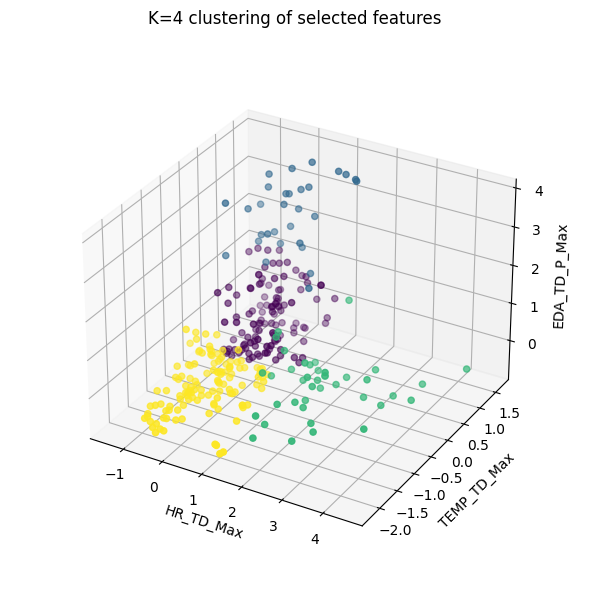

In [35]:
# k means clustering with k = 4
kmeans = KMeans(n_clusters=4).fit(X)
labels = kmeans.labels_

HR = df[X.columns[0]]
TEMP = df[X.columns[1]]
EDA = df[X.columns[2]]

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(projection='3d')
plt.tight_layout()
ax.set_box_aspect(None, zoom=0.85)

ax.scatter(HR, TEMP, EDA, c=labels)
ax.set_xlabel(str(X.columns[0]))
ax.set_ylabel(str(X.columns[1]), labelpad=10)
ax.set_zlabel(str(X.columns[2]))
ax.set_title("K=4 clustering of selected features")

# # plot with one dimension removed
# plt.scatter(HR, TEMP, c=labels)
# plt.xlabel(str(X.columns[0]))
# plt.ylabel(str(X.columns[1]))

plt.savefig("results/3Dplot.pdf")
plt.show()